### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from math import log10, sqrt

from tensorflow.keras import layers
from tensorflow import keras

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    
    # Pad to even number of pixels
    #t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_input = tf.expand_dims(t_input, axis = -1)
    
    # Put channel dim at the end.
    t_input = np.moveaxis(t_input, 1, -1)
    
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Pad to even number of pixels
    #t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_output = tf.expand_dims(t_output, axis = -1)
    
    # Put channel dim at the end.
    t_output = np.moveaxis(t_output, 1, -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
### Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
# Modified to 0-1 scale instead of 0-100
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 1
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr/100

In [5]:
# Inspired by: https://keras.io/examples/vision/video_transformers/?fbclid=IwAR3iwnyxPYjX7dhRnG9tQowO9XJKuAdEyGkTfBWYkeVJTUjNsJtKAsRVWkA
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

In [6]:
# Inspired by: https://keras.io/examples/vision/video_transformers/?fbclid=IwAR3iwnyxPYjX7dhRnG9tQowO9XJKuAdEyGkTfBWYkeVJTUjNsJtKAsRVWkA
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config

In [7]:
# Inspired by: https://keras.io/api/layers/recurrent_layers/time_distributed/
def get_amazon_fire_transformer():
    
    ############## THE ONE ################
    
    # Hyperparamters
    sequence_length = 10
    embed_dim = 1024
    dense_dim = 4
    num_heads = 1
    filters = 256
    
    # Create function call for pretrained CNN.
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(32, 32, 3),
    )
    
    # Freeze most layers of pretrained model.
    #for layer in feature_extractor.layers[:-5]:                                                       
    #    layer.trainable = False
    
    # Add preprocessing to inputs
    preprocess_input = keras.applications.densenet.preprocess_input
    
    # Get inputs and convert to 3-channel format to fit pretrained CNN.
    inputs = keras.Input((10, 32, 32, 2))
    inputs_expanded = tf.keras.layers.Conv2D(3, 1, padding='same')
    
    # Apply time-distributed pretrained CNN to get feature map for each frame.
    x = tf.keras.layers.TimeDistributed(inputs_expanded)(inputs)
    x = preprocess_input(x)
    feature_map = feature_extractor
    x = tf.keras.layers.TimeDistributed(feature_map)(x)
    
    # Note to future self: concatenate vectorized features here.
    
    # Apply positional embedding.
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(x)
    
    # Apply transformer/attention calculation then compress to single frame.
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    # Proceed with deconvolution.
    x = layers.Activation("relu")(x)
    x = layers.Dense(embed_dim, activation='relu')(x)
    x = layers.Dense(embed_dim, activation='relu')(x)
    x = layers.Dense(embed_dim, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape([2,2,int(embed_dim/4)])(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2D(1, 1, padding='same', activation = 'sigmoid')(x)
    
    return keras.Model(inputs, outputs, name="amazon_fire_transformer")

### Load data

In [8]:
# Get data from one chip
m = pd.read_csv('4fold/2017/meta.csv')
sample_input = np.load('4fold/2017/features/25688.npy')
sample_output = np.load('4fold/2017/labels/25688.npy')

# Pad to even number of pixels
#a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
#a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
#a = tf.expand_dims(a, axis = 0)


# Move channel axis to the end
a = np.moveaxis(sample_input, 1, -1)
b = np.moveaxis(sample_output, 0, -1)

# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)
b = tf.expand_dims(b, axis = 0)

# Display shape for verification.
a.shape, b.shape

(TensorShape([1, 10, 32, 32, 2]), TensorShape([1, 32, 32, 1]))

### Model assembly

In [9]:
forecast_model = get_amazon_fire_transformer()

In [10]:
# Verify output shape.
forecast_model.predict(a).shape

1/1 [==============================] - 4s 4s/step


(1, 32, 32, 1)

In [11]:
# Display model details.
forecast_model.summary()

Model: "amazon_fire_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 32, 32, 2)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 32, 32, 3)    9         
 ibuted)                                                         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 10, 32, 32, 3)    0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 10, 32, 32, 3)    0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 10, 32, 32, 3)    0         
 da)                                                             
                                           

In [12]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = tf.keras.losses.MeanSquaredError()
forecast_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy','mean_squared_error'])

In [13]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold/2017/meta.csv')
df_2018 = pd.read_csv('4fold/2018/meta.csv')
df_2019 = pd.read_csv('4fold/2019/meta.csv')
df_2020 = pd.read_csv('4fold/2020/meta.csv')

# Combine into desire train/val split.
meta_t = pd.concat([df_2017,df_2018,df_2019])
meta_v = df_2020

# Data loaders.
batch_size = 32
#t_gen = data_generator(meta_t, batch_size = batch_size)
#v_gen = data_generator(meta_v, batch_size = batch_size)

In [14]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features))
    y_train.append(np.load(meta_t.iloc[x].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

# Move channel dims to last.
x_train = np.moveaxis(x_train, 2, -1)
y_train = tf.expand_dims(y_train, axis = -1).numpy()
x_val = np.moveaxis(x_val, 2, -1)
y_val = tf.expand_dims(y_val, axis = -1).numpy()

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((15000, 10, 32, 32, 2),
 (15000, 1, 32, 32, 1),
 (5000, 10, 32, 32, 2),
 (5000, 1, 32, 32, 1))

In [16]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [17]:
# Get class weights for weighted binary cross entropy loss.
weights = class_weight.compute_class_weight('balanced',
                                            [0,1],
                                            y_train.flatten())
# Examine weights.
weights

C:\Users\covad\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 0.50495932, 50.91015154])

In [18]:
# To-do: Try watering-down the weights.

In [19]:
calculated_sample_weights = generate_sample_weights(y_train, weights)

In [20]:
# Move numpy objects to tensors.
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
calculated_sample_weights = tf.convert_to_tensor(calculated_sample_weights)

In [21]:
# Validate weight matrix shape.
calculated_sample_weights.shape == y_train.shape

True

In [22]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=1)

# Train model.
forecast_model.fit(x_train,
                   y_train[:,0],
                   epochs = 20, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val[:,0]),
                   callbacks = [early_stopping, reduce_lr],
                   sample_weight = calculated_sample_weights[:,0]
                  )

Epoch 1/20
469/469 [==============================] - 68s 120ms/step - loss: 0.2092 - accuracy: 0.6237 - mean_squared_error: 0.2672 - val_loss: 0.1280 - val_accuracy: 0.8797 - val_mean_squared_error: 0.1280 - lr: 1.0000e-05
Epoch 2/20
469/469 [==============================] - 53s 114ms/step - loss: 0.1789 - accuracy: 0.7136 - mean_squared_error: 0.2331 - val_loss: 0.3588 - val_accuracy: 0.5265 - val_mean_squared_error: 0.3588 - lr: 1.0000e-05
Epoch 3/20
469/469 [==============================] - 54s 114ms/step - loss: 0.1702 - accuracy: 0.7379 - mean_squared_error: 0.2183 - val_loss: 0.2450 - val_accuracy: 0.6970 - val_mean_squared_error: 0.2450 - lr: 1.0000e-06
Epoch 4/20
469/469 [==============================] - 53s 113ms/step - loss: 0.1693 - accuracy: 0.7413 - mean_squared_error: 0.2158 - val_loss: 0.2383 - val_accuracy: 0.7071 - val_mean_squared_error: 0.2383 - lr: 1.0000e-07
Epoch 5/20
469/469 [==============================] - 53s 113ms/step - loss: 0.1693 - accuracy: 0.7411 -

In [23]:
# Save trained model.
forecast_model.save('Models/VTR_04_2020/model.h5')

In [24]:
#forecast_model = tf.keras.models.load_model('Models/VTR_01_2020/model.h5',
#                                           custom_objects={'PositionalEmbedding': PositionalEmbedding,
#                                                           'TransformerEncoder': TransformerEncoder})

### Examing single-frame predictions

In [25]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
# Extract the model's prediction and post-process it.
new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
#new_prediction = np.squeeze(new_prediction, axis=0)
#predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
#pred_frames.append(predicted_frame)
pred_frames.append(new_prediction)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 2s 2s/step


In [26]:
# Shape verification.
label_frames.shape, pred_frames.shape

(TensorShape([1, 32, 32, 1]), (1, 32, 32, 1))

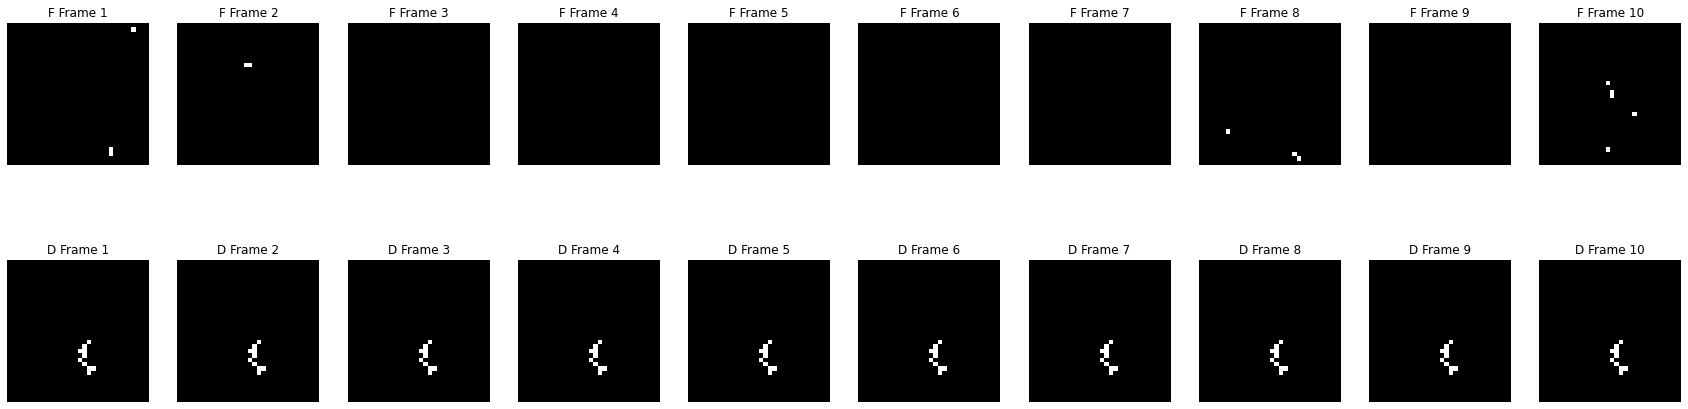

In [27]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,:1]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Plot the deforestation frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,1:2]), cmap="gray")
    ax.set_title(f"D Frame {idx + 1}")
    ax.axis("off")
    
# Display the figure.
plt.show()

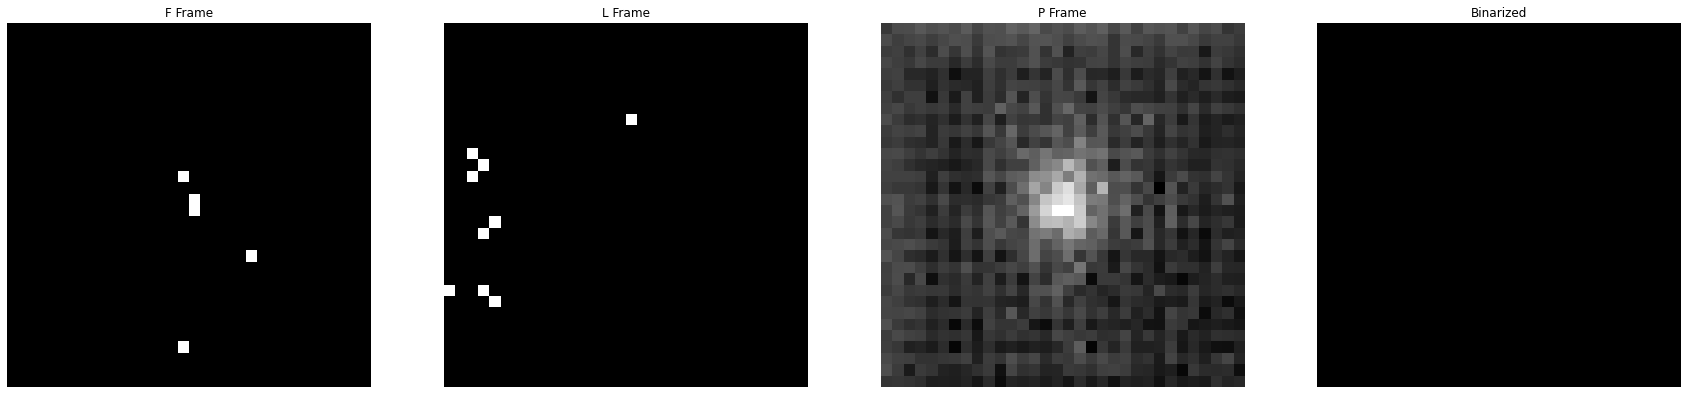

In [28]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Plot the last feature frame.
axes[0].imshow(np.squeeze(feature_frames[9][:,:,:1]), cmap="gray")
axes[0].set_title(f"F Frame")
axes[0].axis("off")

# Plot the label frame.
axes[1].imshow(np.squeeze(label_frames[0]), cmap="gray")
axes[1].set_title(f"L Frame")
axes[1].axis("off")
    
# Plot the predicted frame.
axes[2].imshow(np.squeeze(pred_frames[0]), cmap="gray")
axes[2].set_title(f"P Frame")
axes[2].axis("off")

# Plot binarized prediction.
axes[3].imshow(np.squeeze(np.where(pred_frames > 0.85, 1, 0)), cmap="gray")
axes[3].set_title(f"Binarized")
axes[3].axis("off")

# Display the figure.
plt.show()

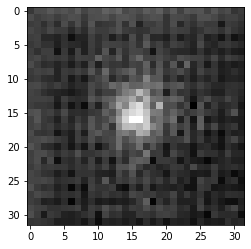

In [29]:
pred_frames[0]
plt.imshow(np.squeeze(pred_frames[0]), cmap="gray")

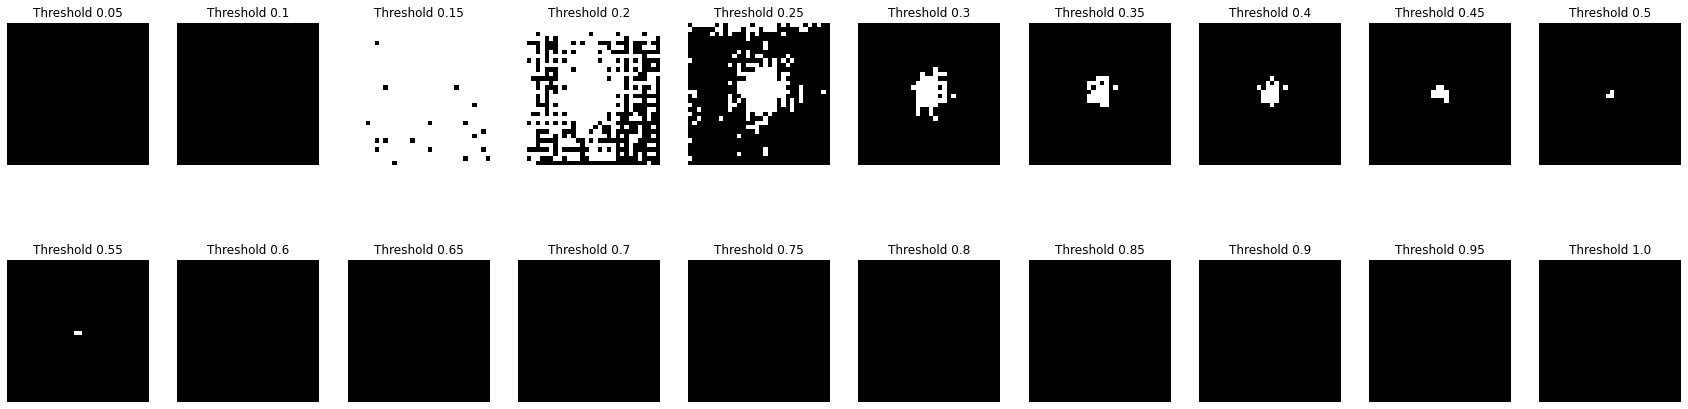

In [30]:
# Construct a figure to show all prediction thresholds.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 1) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 1) * 0.05, 2)}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 11) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 11) * 0.05, 2)}")
    ax.axis("off")
    
# Display the figure.
plt.show()

In [31]:
# Get first sample IoU
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(pred_frames > t, 1, 0), label_frames[0])
    union = np.logical_or(np.where(pred_frames > t, 1, 0), label_frames[0])
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.0087890625),
 (0.05, 0.0087890625),
 (0.1, 0.0087890625),
 (0.15, 0.008946322067594433),
 (0.2, 0.008595988538681949),
 (0.25, 0.0),
 (0.3, 0.0),
 (0.35, 0.0),
 (0.4, 0.0),
 (0.45, 0.0),
 (0.5, 0.0),
 (0.55, 0.0),
 (0.6, 0.0),
 (0.65, 0.0),
 (0.7, 0.0),
 (0.75, 0.0),
 (0.8, 0.0),
 (0.85, 0.0),
 (0.9, 0.0),
 (0.95, 0.0),
 (1.0, 0.0)]

### Get IoU for full prediction set.

In [32]:
# Predict on everything.
all_preds = forecast_model.predict(x_val)

157/157 [==============================] - 6s 22ms/step


In [33]:
'''# Get IoU.
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)
    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious
'''

'# Get IoU.\nthresholds = [x/100 for x in range(0,105,5)]\nious = []\nfor t in thresholds:\n    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)\n    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)\n    iou_score = np.sum(intersection) / np.sum(union)\n    ious.append((t,iou_score))\nious\n'

In [34]:
# Get MSE.
mses = [mean_squared_error(all_preds[x], y_val[x][0].numpy()) for x in range(0,len(all_preds))]
mean_squared_error(all_preds, y_val[:,0].numpy())

0.12804907768612392

In [35]:
## Get SSIM if masking is applied.
## Calculation seems to be skewed and giving unreasonably high scores with masking applied.
#thresholds = [x/100 for x in range(0,105,5)]
#masked_ssims = []
#for t in thresholds:
#    t_ssim = [ssim(np.where(all_preds[x][0] > t, 1, 0), y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
#    t_ssim2 = sum(t_ssim) / len(t_ssim)
#    masked_ssims.append((t,t_ssim2))
#masked_ssims

In [36]:
# Get Peak Signal-to-Noise Ratio (PSNR)
psnrs = [PSNR(all_preds[x], y_val[x][0].numpy()) for x in range(0,len(all_preds))]
set_psnr = sum(psnrs) / len(psnrs)
set_psnr

0.09929204342355054

In [37]:
# Get raw mean SSIM
ssims = [ssim(all_preds[x], y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
mean_raw_ssim = sum(ssims) / len(ssims)
mean_raw_ssim

C:\Users\covad\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


0.01035036276413315

In [38]:
# Get DataFrame of all prediction grades.
rows = []
#for s in range(0,len(all_preds)): 
#    thresholds = [x/100 for x in range(0,105,5)]
#    t_ious = []
#    for t in thresholds:
#        intersection = np.logical_and(np.where(all_preds[s] > t, 1, 0), y_val[s])
#        union = np.logical_or(np.where(all_preds[s] > t, 1, 0), y_val[s])
#        if np.sum(union) > 0:
#            iou_score = np.sum(intersection) / np.sum(union)
#        else:
#            iou_score = 0
#        t_ious.append(iou_score)
#    rows.append(t_ious)
#iou_df = pd.DataFrame(rows)
iou_df = pd.DataFrame()
iou_df['ssim'] = ssims
iou_df['mse'] = mses
iou_df['psnr'] = psnrs

### Examining Good Predictions

0.1006100637094115

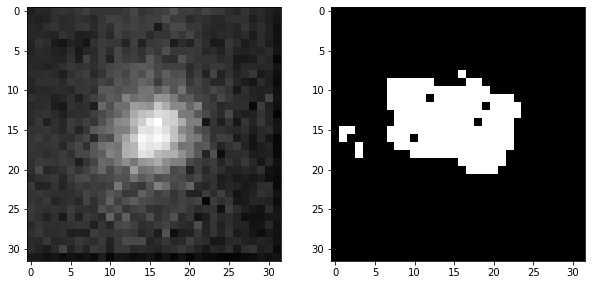

In [39]:
# Examining the best SSIM
x = iou_df.sort_values(by = 'ssim', ascending = False).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
ssims[x]

0.0369129564497838

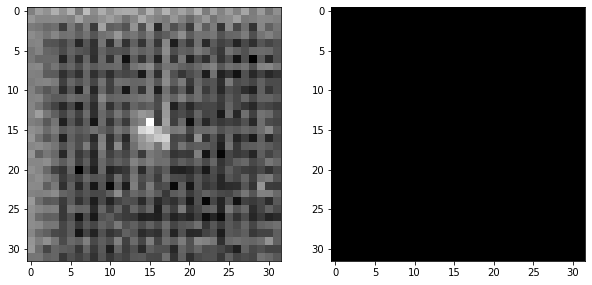

In [40]:
# Examining the best MSE
x = iou_df.sort_values(by = 'mse', ascending = True).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
mses[x]

In [41]:
#iou_df.max()

In [42]:
#iou_df[18].sort_values(ascending = False)

In [43]:
'''# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(3, 5, figsize=(20, 12))

# List of samples to check:
tgts = list(iou_df[18].sort_values(ascending = False)[2:5].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=20)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=20)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=20)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=20)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=20)
    axes[4].axis("off")

# Display the figure.
plt.show()
'''

'# Construct a figure for the original and new frames.\nfig, all_axes = plt.subplots(3, 5, figsize=(20, 12))\n\n# List of samples to check:\ntgts = list(iou_df[18].sort_values(ascending = False)[2:5].index)\nx = -1\n\nfor axes in all_axes:\n    x += 1\n    \n    # Plot deforestaion.\n    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")\n    axes[0].set_title("Deforestation", fontsize=20)\n    axes[0].axis("off")\n    \n    # Plot the last feature frame.\n    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")\n    axes[1].set_title("Fires", fontsize=20)\n    axes[1].axis("off")\n\n    # Plot the label frame.\n    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")\n    axes[2].set_title("Target", fontsize=20)\n    axes[2].axis("off")\n\n    # Plot the predicted frame.\n    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")\n    axes[3].set_title("Prediction", fontsize=20)\n    axes[3].axis("off")\n\n    # Plot binarized prediction.\n  

### Examining Pretty Bad Predictions

In [44]:
#iou_df[iou_df[19] > 0.02][19].sort_values()

In [45]:
'''# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(3, 5, figsize=(20, 12))

# List of samples to check:
tgts = list(iou_df[(iou_df[18] > 0.11) & (iou_df[18] < 0.13)][18].sort_values()[:3].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=20)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=20)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=20)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=20)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=20)
    axes[4].axis("off")

# Display the figure.
plt.show()
'''

'# Construct a figure for the original and new frames.\nfig, all_axes = plt.subplots(3, 5, figsize=(20, 12))\n\n# List of samples to check:\ntgts = list(iou_df[(iou_df[18] > 0.11) & (iou_df[18] < 0.13)][18].sort_values()[:3].index)\nx = -1\n\nfor axes in all_axes:\n    x += 1\n    \n    # Plot deforestaion.\n    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")\n    axes[0].set_title("Deforestation", fontsize=20)\n    axes[0].axis("off")\n    \n    # Plot the last feature frame.\n    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")\n    axes[1].set_title("Fires", fontsize=20)\n    axes[1].axis("off")\n\n    # Plot the label frame.\n    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")\n    axes[2].set_title("Target", fontsize=20)\n    axes[2].axis("off")\n\n    # Plot the predicted frame.\n    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")\n    axes[3].set_title("Prediction", fontsize=20)\n    axes[3].axis("off")\n\n    # Plot 

In [46]:
'''# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(3, 5, figsize=(20, 12))

# List of samples to check:
tgts = list(iou_df[iou_df[18] < 0.039][18].sort_values()[:3].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=20)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=20)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=20)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=20)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=20)
    axes[4].axis("off")

# Display the figure.
plt.show()
'''

'# Construct a figure for the original and new frames.\nfig, all_axes = plt.subplots(3, 5, figsize=(20, 12))\n\n# List of samples to check:\ntgts = list(iou_df[iou_df[18] < 0.039][18].sort_values()[:3].index)\nx = -1\n\nfor axes in all_axes:\n    x += 1\n    \n    # Plot deforestaion.\n    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")\n    axes[0].set_title("Deforestation", fontsize=20)\n    axes[0].axis("off")\n    \n    # Plot the last feature frame.\n    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")\n    axes[1].set_title("Fires", fontsize=20)\n    axes[1].axis("off")\n\n    # Plot the label frame.\n    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")\n    axes[2].set_title("Target", fontsize=20)\n    axes[2].axis("off")\n\n    # Plot the predicted frame.\n    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")\n    axes[3].set_title("Prediction", fontsize=20)\n    axes[3].axis("off")\n\n    # Plot binarized prediction.\n

In [47]:
# Print all set metrics again for ease of gathering.
print('ssim',mean_raw_ssim)
print('psnr',set_psnr)
print('mse',mean_squared_error(all_preds, y_val.numpy()[:,0]))
#ious

ssim 0.01035036276413315
psnr 0.09929204342355054
mse 0.12804907768612392
